### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

### №1. Что такое tfidf

TF-IDF(term frequency — inverse document frequency) - метод, способный понижать оценку слова, которое часто встречается во всех схожих документах. Это статистическая мера для оценки важности слова в документе, который является частью коллекции или корпуса.

* TF (term frequency — частота слова) – отношение числа вхождений слова к общему числу слов документа.
* TF = сколько раз слово появлялось в документе ,деленное на  общее кол-во итемов в документе

* IDF (inverse document frequency — обратная частота документа) — инверсия частоты, с которой некоторое слово встречается в документах коллекции.
* IDF = логарифм частного общего кол-во документов и кол-ва документов, в которых встречается это слово




    from sklearn.feature_extraction.text import TfidfVectorizer

Тренируем модель

    tfidf_vectorizer = TfidfVectorizer()
    values = tfidf_vectorizer.fit_transform(документы)

Покажем результат как датафрейм

    feature_names = tfidf_vectorizer.get_feature_names()
    pd.DataFrame(values.toarray(), columns = feature_names)


###  №2,3,5 Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [1]:
import pandas as pd
import re
import itertools
import numpy as np
from nltk.corpus import stopwords
from razdel import tokenize
import pymorphy2
from gensim.test.utils import common_texts
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score , roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

%matplotlib inline

In [2]:
# Расстояние Левенштейна
#!pip install python-Levenshtein

In [3]:
# подгружаем стоп-слова и данные
import nltk
nltk.download('stopwords')
news = pd.read_csv('articles.csv')
users = pd.read_csv('users_articles.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mahhets\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Получим векторные представления наших данных(текста новостей)

In [4]:
# Подгружаем русские стоп-слова
stopword_ru = stopwords.words('russian')

with open('stopwords.txt') as f:
    adittional_stopwords = [w.strip() for w in f.readlines()if w]
stopword_ru += adittional_stopwords
# Создаем объект для морфологического анализа(позволяет интерпретировать слова в нормальную форму)
morph = pymorphy2.MorphAnalyzer()

методы очистки возьму из урока

In [5]:

def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str): # функция isinstance проверяет принадлежность экземпляра к классу
        text = str(text)
    
    text = text.lower() # делаем все буквы маленькими
    text = text.strip('\n').strip('\r').strip('\t') # удаляет начальные и конечные символы в строке
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text)) # re.sub ищет шаблон в подстроке и заменяет его на строку

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub("n", ' ', text)
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

# Лемматизация(еще есть стэмминг(попытается отбросить суффикс), процедура легкая, но грубая)
# Лемматизация превращает различные формы слов в меньшее кол-во вариантов этих слов с минимум потери смысловой нагрузки
def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text)) # Токенизация(разделяем текст на отдельные куски)
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6] Отделяем от стоп-слов
    
    return words_lem_without_stopwords

In [6]:
%%time
news['title'] = news['title'].apply(lambda x: clean_text(x), 1) # Запустим очистку для всего документа
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1) # Запустим нормализацию(лемматизацию) для всего текста

<ipython-input-5-dfdd240aca0b>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 2min 59s


In [7]:
# разбиваем текст по значениям, где слово = значение
texts = [t for t in news['title'].values]

# далее сформируем наш словарь и на его базе создадим "мешок слов"
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [8]:
# следующим шагом обучим LDA модель, предположив разбиение на 25 тем
N_topic = 25
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)

In [9]:
# Функция построения LDA вектора для нашего текста
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text) # получили преобразование текста в id по нашему словарю(перестоили в bag of words)
    lda_tuple = lda[unseen_doc] # закинули это в LDA
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [10]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.050708,0.000000,0.00000,0.0,0.053994,0.0,0.363858,...,0.0,0.0,0.0,0.0,0.0,0.412623,0.0,0.0,0.000000,0.0
1,4896,0.0,0.0,0.000000,0.080526,0.00000,0.0,0.896469,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,4897,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.366704,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.612453,0.0
3,4898,0.0,0.0,0.000000,0.000000,0.02655,0.0,0.152054,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.810613,0.0
4,4899,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.119797,0.0,0.854632,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


Полученный датафрейм векторов можно интерпретировать как векторa вероятностей принадлежности теме(topic_n) для каждого документа(doc_id)

#### Теперь нам нужно векторно представить пользователей

In [11]:
# построим соответствие id статей с конкретными векторами
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))

In [12]:
# сопосталяем пользователя и список тем
def get_user_embedding(user_articles_list, method):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector[0])
    return method(user_vector,0)

# Если раздокументировать print, то мы смоем наблюдать вектора каждого пользователя
#Тоесть это какие-то точки в пространсве тем, благодаря чему пользователей даже можно сигментировать по интересам

In [13]:
# Для каждого из методов посчитаем тематическую матрицу и сопоставим с пользователями
methods = [np.mean, np.median, np.amax]
embeddings = []
for method in methods:
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, method), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
    embeddings.append(user_embeddings)

#### Векторные представления готовы, попробуем обучить модель

In [14]:
target = pd.read_csv('users_churn.csv')
#X = pd.merge(user_embeddings, target, 'left') # мерджим таблицу наших векторных пользователей с нашим таргетом таргетом(оттоком)

In [15]:
# Для каждого эмбеддинга обучим модель и соберем предикты
logred = LogisticRegression()
predicts = []
for i in range(len(embeddings)):
    X = pd.merge(embeddings[i], target, 'left')
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)
    logred.fit(X_train, y_train)
    preds = logred.predict_proba(X_test)[:,1]
    predicts.append(preds)

In [16]:
predicts[1]

array([0.10382513, 0.05994021, 0.31504607, ..., 0.0075576 , 0.05020155,
       0.00200471])

In [17]:
# Найдем точность, полноту и порог для каждой пробы, сохраним
#np.seterr(divide='ignore', invalid='ignore') # это для того, чтобы numpy закрывал глаза на ошибки
mods = ['mean','median','max']
precisions, recalls, thresholds, f_scores = [], [], [], []
for i in range(len(predicts)):
    precision, recall, th = precision_recall_curve(y_test.values, predicts[i])
    fscore = ((2 * precision * recall) + 0.000001) / ((precision + recall)+ 0.000001)
    ix = np.argmax(fscore)
    precisions.append(precision[ix])
    recalls.append(recall[ix])
    thresholds.append(th[ix])
    f_scores.append(fscore[ix])
    print(f'For {mods[i]} Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (th[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
    


For mean Best Threshold=0.266237, F-Score=0.596, Precision=0.564, Recall=0.633
For median Best Threshold=0.270660, F-Score=0.691, Precision=0.626, Recall=0.771
For max Best Threshold=0.369699, F-Score=0.775, Precision=0.800, Recall=0.751


In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
inf = np.vstack((precisions,recalls,thresholds, f_scores))
pd.DataFrame(data = inf.T, index=['mean','median','max'], columns=['precision', 'recall', 'threshold', 'f_score'])

,precision,recall,threshold,f_score
mean,0.563636,0.632653,0.266237,0.596154
median,0.625828,0.771429,0.270660,0.691042
max,0.800000,0.751020,0.369699,0.774737


Confusion matrix, without normalization
[[1635  120]
 [  91  154]]
Confusion matrix, without normalization
[[1642  113]
 [  57  188]]
Confusion matrix, without normalization
[[1709   46]
 [  62  183]]


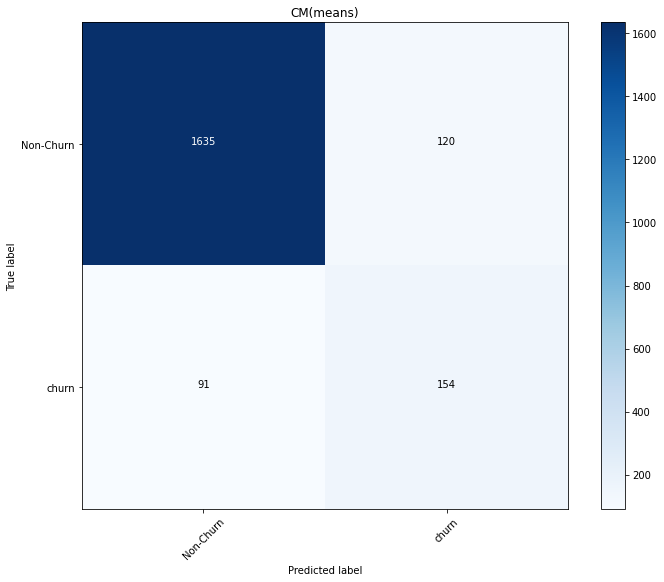

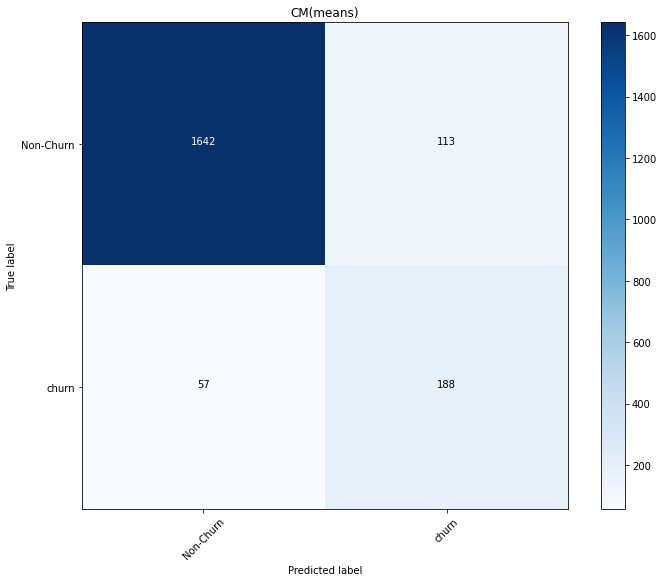

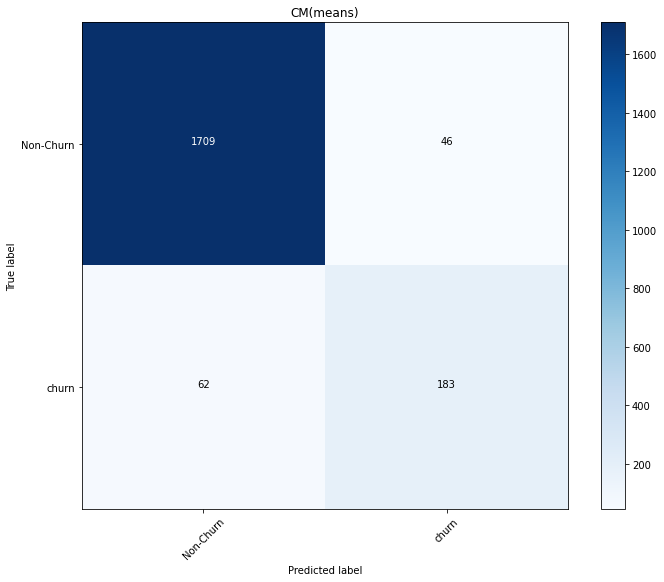

In [20]:
cnf_matrix = confusion_matrix(y_test, predicts[0]>thresholds[0])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='CM(means)')

cnf_matrix = confusion_matrix(y_test, predicts[1]>thresholds[1])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='CM(means)')

cnf_matrix = confusion_matrix(y_test, predicts[2]>thresholds[2])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='CM(means)')


### №6 Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Самый эффективный способ - max.
При максимальном значении из вектора пользователя мы получаем его самую стабильную,с точки зрения просмотров, тему.
Это позволяет лучше сегментировать пользователей по интересам, но предположу, что это не хорошо, ибо мы теряем другую важную информацию о пользователе, теряем побочные интересы(приятные бонусы и т.д.), которые суммарно могут сильнее удерживать клиента, чем основной предмет внимания.

1. Я заметил, что если не добавлять в стандартный словарь стоп-слов дополнительные слова, то один из методов эмбеддинга пользователей(mean, median, max) работает некорректно(присутсвуют nan значения)
2. Такое ощущение, что чем больше тем мы предполагаем, тем лучше работает LDA(возможно до какого-то порога)